## Plot stats of isolated vs. repeating moonquakes

### Import libraries

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import os
import glob
import sys
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib import gridspec

# Import functions
fxndir = '../functions/'
sys.path.insert(0,fxndir)
from moon2data import *
from moonquake_temperatures import *

### Load catalog of high quality isolated and repeating moonquakes

In [2]:
# Load combined catalog
mqdir = '../catalogs/final_catalogs/'
cat = pd.read_csv(mqdir + 'A17_moonquakes_catalog_HQ_avg_event_stats.csv')
cat.drop(list(cat.filter(regex='Unnamed|index')), axis=1, inplace=True)

# Isolated
isolated_cat = cat.loc[cat.isol_or_rpt == 'isolated']
pgvs_isolated = np.array(isolated_cat.avg_PGV.tolist())
emergences_isolated = np.array(isolated_cat.avg_emergence_s.tolist())
days_isolated = np.array(isolated_cat.avg_interval_day.tolist())
# Azimuths
# Lag
isolated_cat = isolated_cat.loc[isolated_cat.theta_mean_lag_deg > 0]
thetas_isol_lag = np.array(isolated_cat.theta_mean_lag_deg)
sds_isol_lag = np.array(isolated_cat.theta_sd_lag_deg)
# SNR
thetas_isol_snr = np.array(isolated_cat.theta_mean_snr_deg)
sds_isol_snr = np.array(isolated_cat.theta_sd_snr_deg)

# Repeating
repeating_cat = cat.loc[cat.isol_or_rpt == 'repeating']
evid_refs = np.unique(repeating_cat.evid_ref.tolist())
pgvs_repeating = np.array(repeating_cat.avg_PGV.tolist())
emergences_repeating = np.array(repeating_cat.avg_emergence_s.tolist())
days_repeating = np.array(repeating_cat.avg_interval_day.tolist())
# Azimuths
# Lag
repeating_cat = repeating_cat.loc[repeating_cat.theta_mean_lag_deg > 0]
thetas_rpt_lag = np.array(repeating_cat.theta_mean_lag_deg)
sds_rpt_lag = np.array(repeating_cat.theta_sd_lag_deg)
# SNR
thetas_rpt_snr = np.array(repeating_cat.theta_mean_snr_deg)
sds_rpt_snr = np.array(repeating_cat.theta_sd_snr_deg)

# Durations
cat2 = pd.read_csv(mqdir + 'A17_moonquakes_catalog_HQ_final.csv')
cat2 = cat2.loc[cat2.theta_mean_lag_deg > 0]
cat2.drop(list(cat2.filter(regex='Unnamed|index')), axis=1, inplace=True)
durations_isolated = np.array(cat2.loc[cat2.isol_or_rpt == 'isolated'].duration_s.tolist())
durations_repeating = np.array(cat2.loc[cat2.isol_or_rpt == 'repeating'].duration_s.tolist())

### Isolate 25 largest families

In [3]:
numevts = []
for evid in evid_refs:
    rows = repeating_cat.loc[repeating_cat.evid_ref == evid]
    numevts.append(len(rows))
    
df = pd.DataFrame(data = {'evid_ref':evid_refs, 'numevts':numevts})
df = df.sort_values(by=['numevts'],ascending=False,ignore_index=True)
evid_refs = np.array(df.evid_ref.tolist())[0:25]

### Load temperature data

In [4]:
tempdir = '../catalogs/temperature/'
temp_df, int_df = load_temp_cats(tempdir)

# Start and end time of one cycle
starttime_str = int_df.iloc[0]['start times']
starttime = datetime.strptime(int_df.iloc[0]['start times'],'%Y-%m-%d %H:%M:%S')
endtime_str = int_df.iloc[2]['end times']
endtime = datetime.strptime(int_df.iloc[2]['end times'],'%Y-%m-%d %H:%M:%S')

# One cycle
temp_df_day = temp_df.loc[(temp_df.Time_YMD >= starttime_str) & (temp_df.Time_YMD <= endtime_str)]
times_day = np.array(temp_df_day.Time_s.tolist())/(3600*24)
rock_temps_day = np.array(temp_df_day.T_rock_K.tolist())
reg_temps_day = np.array(temp_df_day.T_reg_K.tolist())

# Entire timeframe
temp_reg = np.array(temp_df.T_reg_K.tolist())
temp_rock = np.array(temp_df.T_rock_K.tolist())
temp_diff = temp_rock - temp_reg
time_ymd = [datetime.strptime(mqdate, '%Y-%m-%d %H:%M:%S') for mqdate in (temp_df['Time_YMD']).tolist()]

### Put everything in one plot

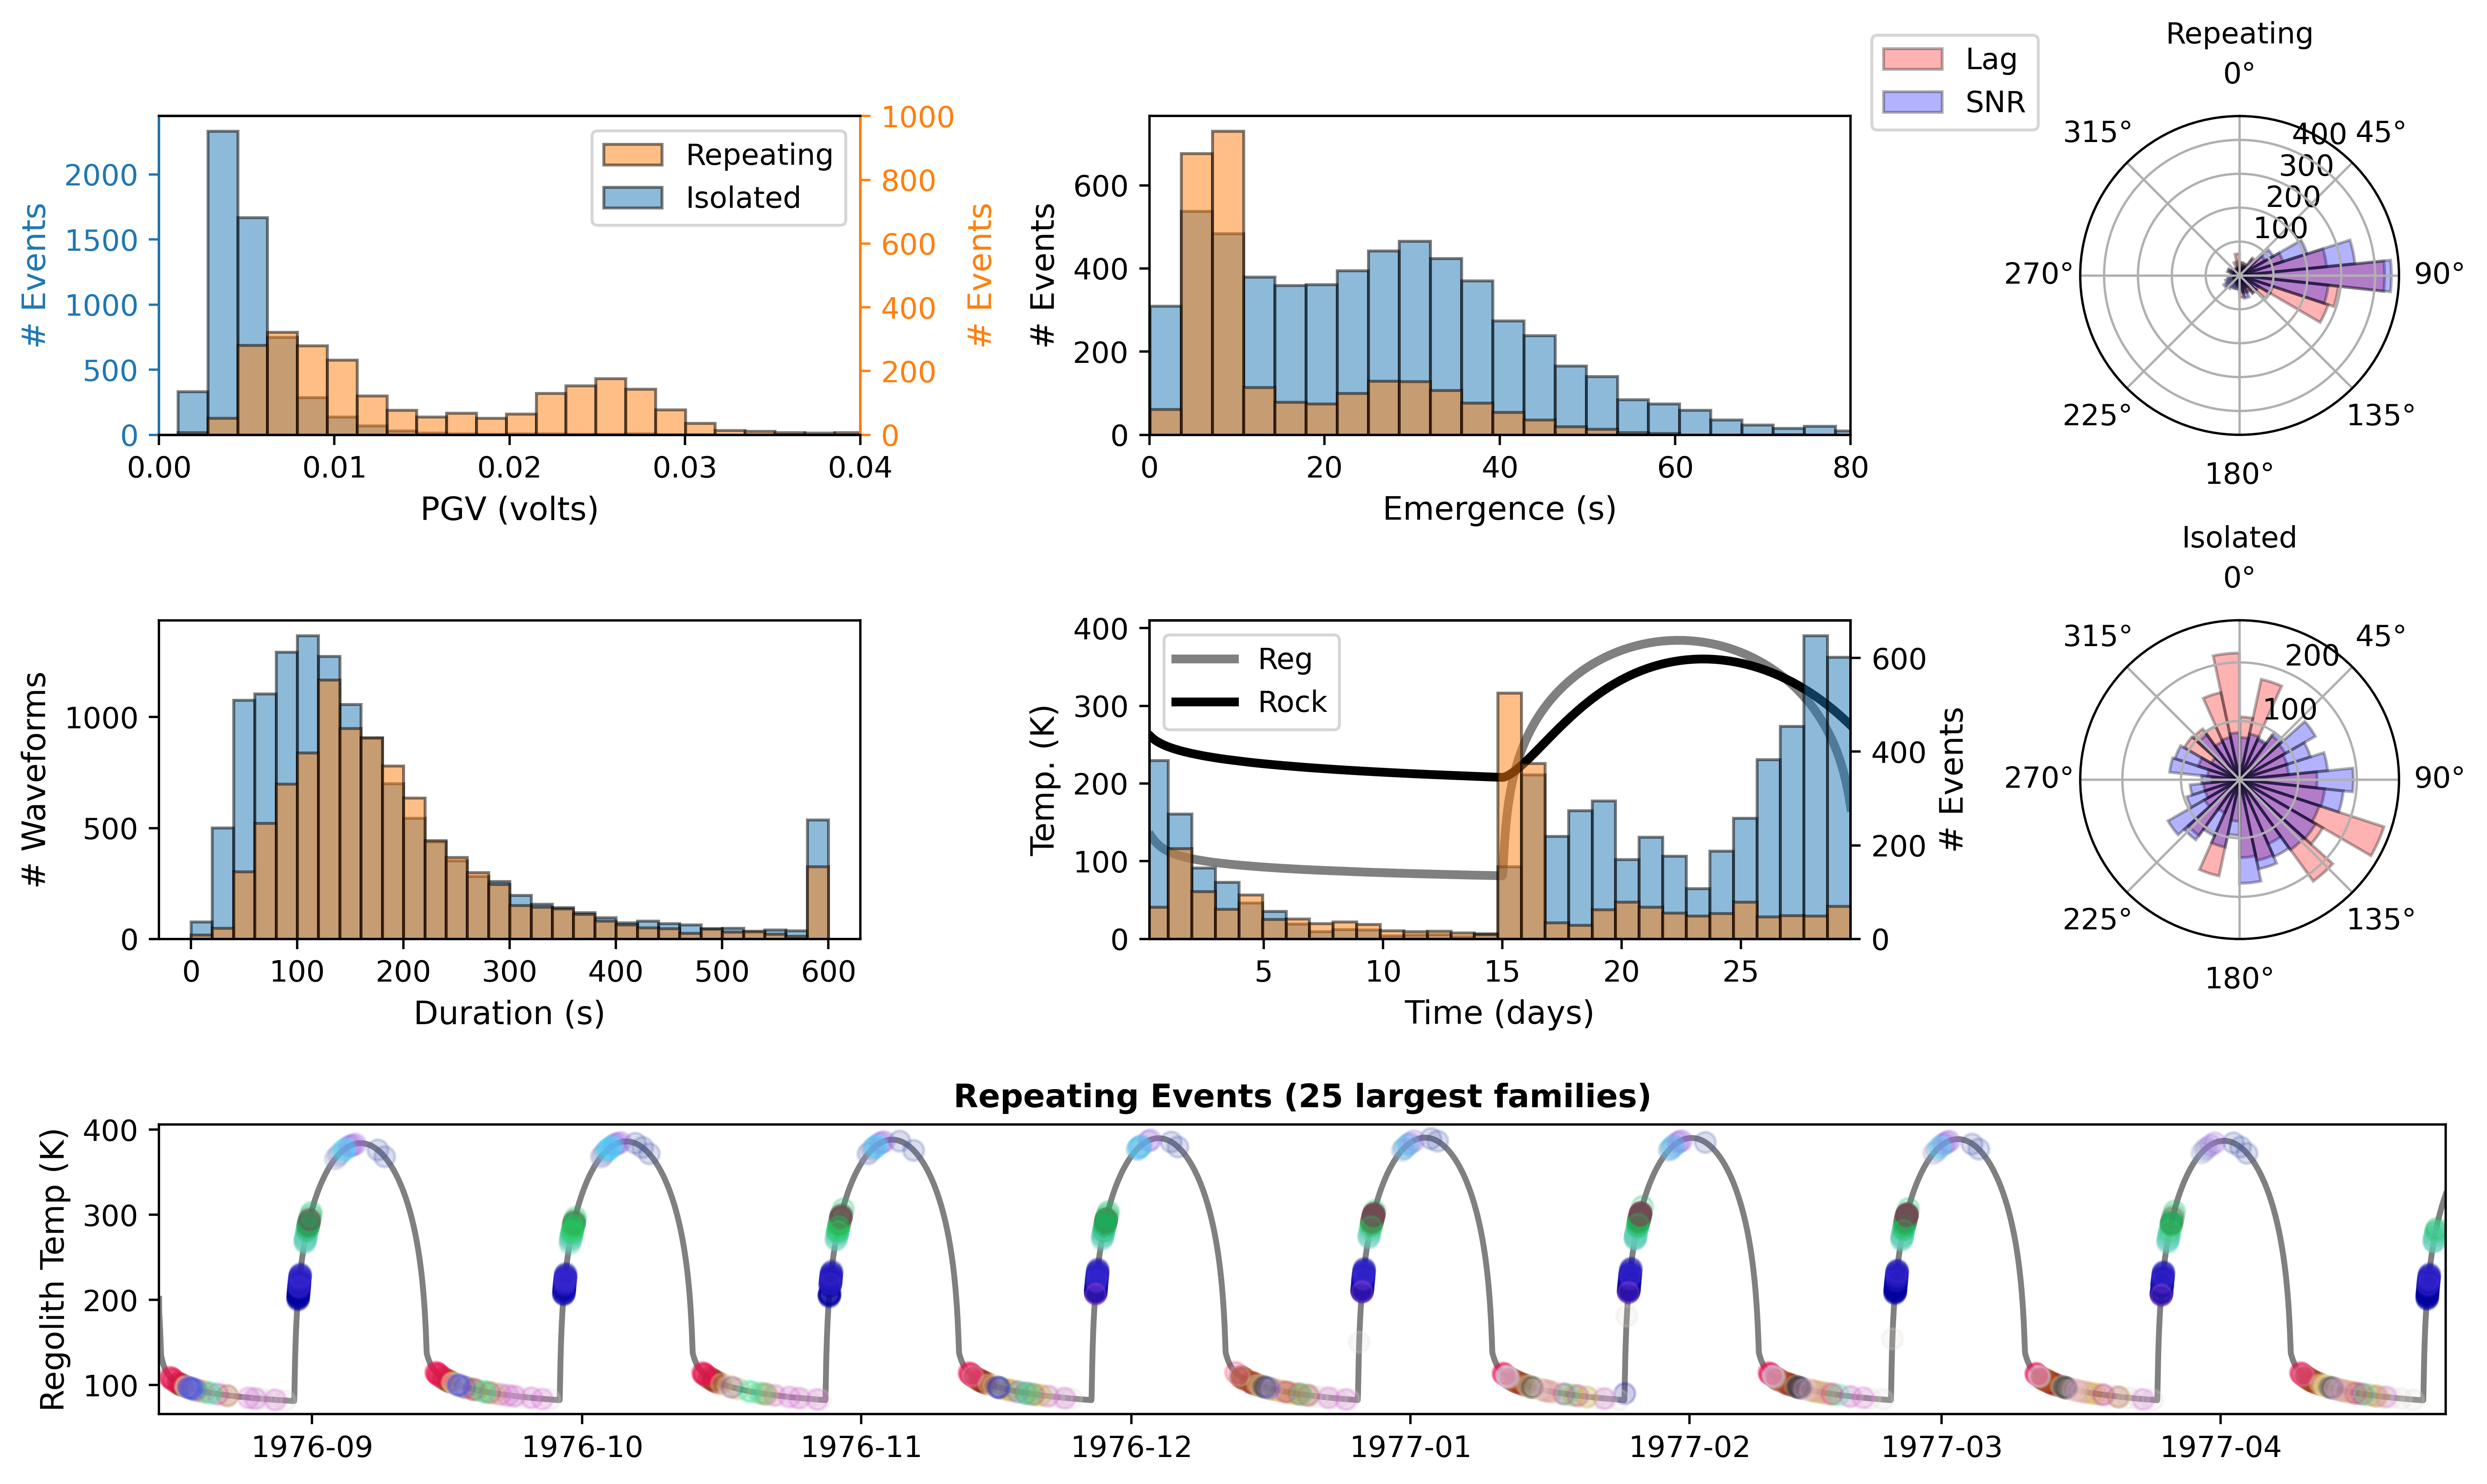

In [8]:
# Initialize figure
fig = plt.figure(figsize=(14., 8.),dpi=500)
gs = gridspec.GridSpec(3, 3, width_ratios=(1.7,1.7,1.), height_ratios=(1.1, 1.1, 1)) 

# PGV
ax_pgv = fig.add_subplot(gs[0, 0])
bins = np.histogram(np.hstack((pgvs_isolated,pgvs_repeating)), bins=80)[1]
ax_pgv.hist(pgvs_isolated,alpha=0.5,color='C0',bins=bins,edgecolor='black',label='Isolated')
ax_pgv.set_xlabel('PGV (volts)',fontsize=11)
ax_pgv.set_ylabel('# Events',fontsize=11,color='C0')
ax_pgv.tick_params(axis='both',labelsize=10)
ax_pgv.tick_params(axis='y',colors='C0')
ax2_pgv = ax_pgv.twinx()
ax2_pgv.hist(pgvs_repeating,alpha=0.5,color='C1',bins=bins,edgecolor='black',label='Repeating')
ax2_pgv.set_ylim([0,1000])
ax2_pgv.set_ylabel('# Events',fontsize=11,color='C1')
ax2_pgv.tick_params(axis='both',labelsize=10)
ax2_pgv.spines['left'].set_color('C0')
ax2_pgv.spines['right'].set_color('C1')
ax2_pgv.tick_params(axis='y', colors='C1') 
ax_pgv.set_xlim([0,0.04])
# Legend
hists = [ax2_pgv.get_children()[0], ax_pgv.get_children()[0]]
histlabels = ['Repeating', 'Isolated']
ax_pgv.legend(hists, histlabels, loc='upper right')

# Emergence
ax_emg = fig.add_subplot(gs[0, 1])
bins = np.histogram(np.hstack((emergences_isolated,emergences_repeating)), bins=30)[1]
ax_emg.hist(emergences_isolated,alpha=0.5,color='C0',bins=bins,edgecolor='black',label='Isolated')
ax_emg.hist(emergences_repeating,alpha=0.5,color='C1',bins=bins,edgecolor='black',label='Repeating')
ax_emg.set_xlim([0,80])
ax_emg.set_ylabel('# Events',fontsize=11)
ax_emg.tick_params(axis='both',labelsize=10)
ax_emg.set_xlabel('Emergence (s)',fontsize=11)

# Duration
ax_dur = fig.add_subplot(gs[1, 0])
bins = np.histogram(np.hstack((durations_isolated,durations_repeating)), bins=30)[1]
ax_dur.hist(durations_isolated,alpha=0.5,color='C0',bins=bins,edgecolor='black',label='Isolated')
ax_dur.hist(durations_repeating,alpha=0.5,color='C1',bins=bins,edgecolor='black',label='Repeating')
ax_dur.set_ylabel('# Waveforms',fontsize=11)
ax_dur.tick_params(axis='both',labelsize=10)
ax_dur.set_xlabel('Duration (s)',fontsize=11)

# Temperature
ax_temp = fig.add_subplot(gs[1, 1])
ax_temp.plot(times_day,reg_temps_day,color='grey',label='Reg',linewidth=3)
ax_temp.plot(times_day,rock_temps_day,color='black',label='Rock',linewidth=3)
ax_temp.set_xlim([0.2,29.6])
ax_temp.set_ylim([0,410])
ax_temp.legend(loc='upper left')
ax_temp.set_ylabel('Temp. (K)',fontsize=11)
ax_temp.tick_params(axis='both',labelsize=10)
ax_temp.set_xlabel('Time (days)',fontsize=11)
ax2_temp = ax_temp.twinx()
bins = np.histogram(np.hstack((days_isolated,days_repeating)), bins=30)[1]
ax2_temp.hist(days_isolated,bins=bins,alpha=0.5,color='C0',edgecolor='black',label='Isolated')
ax2_temp.hist(days_repeating,bins=bins,alpha=0.5,color='C1',edgecolor='black',label='Repeating')
ax2_temp.set_ylabel('# Events',fontsize=11)
ax2_temp.tick_params(axis='both',labelsize=10)

# Isolated azimuths
ax_az_isol = fig.add_subplot(gs[1, 2], projection='polar')
numbins = 30
theta_mean_radii = (thetas_isol_lag * np.pi) / 180
counts_lag, histbins_lag = np.histogram(theta_mean_radii, bins=numbins)
histbins_lag = histbins_lag[:-1]
theta_mean_radii = (thetas_isol_snr * np.pi) / 180
counts_snr, histbins_snr = np.histogram(theta_mean_radii, bins=numbins)
histbins_snr = histbins_snr[:-1]
ax_az_isol.bar(histbins_lag, counts_lag, width = histbins_lag[1] - histbins_lag[0], align='edge', color='red', edgecolor='black', alpha=0.3, label='Lag')
ax_az_isol.bar(histbins_snr, counts_snr, width = histbins_snr[1] - histbins_snr[0], align='edge', color='blue', edgecolor='black', alpha=0.3, label='SNR')
ax_az_isol.set_theta_zero_location("N")
ax_az_isol.set_theta_direction(-1)
ax_az_isol.set_title('Isolated',fontsize=10)

# Repeating azimuths
ax_az_rpt = fig.add_subplot(gs[0, 2], projection='polar')
theta_mean_radii = (thetas_rpt_lag * np.pi) / 180
counts_lag, histbins_lag = np.histogram(theta_mean_radii, bins=numbins)
histbins_lag = histbins_lag[:-1]
theta_mean_radii = (thetas_rpt_snr * np.pi) / 180
counts_snr, histbins_snr = np.histogram(theta_mean_radii, bins=numbins)
histbins_snr = histbins_snr[:-1]
ax_az_rpt.bar(histbins_lag, counts_lag, width = histbins_lag[1] - histbins_lag[0], align='edge', color='red', edgecolor='black', alpha=0.3, label='Lag')
ax_az_rpt.bar(histbins_snr, counts_snr, width = histbins_snr[1] - histbins_snr[0], align='edge', color='blue', edgecolor='black', alpha=0.3, label='SNR')
ax_az_rpt.set_theta_zero_location("N")
ax_az_rpt.set_theta_direction(-1)
ax_az_rpt.set_title('Repeating',fontsize=10)
ax_az_rpt.legend(loc='upper left',bbox_to_anchor=(-0.7,1.3))

# Repeating temperatures
ax_temp_rpt = fig.add_subplot(gs[2, :])
minind = 0
maxind = len(evid_refs)
norm = mcolors.Normalize(vmin=minind, vmax=maxind, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.Spectral)    
ax_temp_rpt.plot(time_ymd,temp_reg,color='grey',zorder=1,linewidth=2)
count = 0
for f in np.arange(0,len(evid_refs)):
    count += 1
    evid_ref = evid_refs[f]
    rows = repeating_cat.loc[repeating_cat.evid_ref == evid_ref]
    if len(rows) >= 3:
        mqtemps = np.array(rows.avg_temp_Regolith_K.tolist())
        mqtimes = [datetime.strptime(mqdate, '%Y-%m-%d %H:%M:%S.%f') for mqdate in (rows['avg_picktime_SNR']).tolist()]
        plotclr = mapper.to_rgba(count)
        plotclr = np.random.rand(3,)
        ax_temp_rpt.scatter(mqtimes,mqtemps,alpha=0.20,s=50,color=plotclr)
ax_temp_rpt.set_xlim([min(time_ymd),max(time_ymd)])
ax_temp_rpt.tick_params(labelsize=10)
ax_temp_rpt.set_ylabel('Regolith Temp (K)',fontsize=11)
ax_temp_rpt.set_title('Repeating Events (25 largest families)',fontweight='bold',fontsize=11)


# Separate subplots
plt.subplots_adjust(wspace = 0.39, hspace = 0.6)
pos = ax_emg.get_position()
pos = pos.bounds
pos_new = [pos[0]+0.018, pos[1], pos[2], pos[3]]
ax_emg.set_position(pos_new)
pos = ax_temp.get_position()
pos = pos.bounds
pos_new = [pos[0]+0.018, pos[1], pos[2], pos[3]]
ax_temp.set_position(pos_new)
pos = ax_temp_rpt.get_position()
pos = pos.bounds
pos_new = [pos[0], pos[1], pos[2], pos[3]]
ax_temp_rpt.set_position(pos_new)